In [41]:

lang = 'en'
fs = 16000 #@param {type:"integer"}
#tag = 'Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave' #@param ["Shinji Watanabe/spgispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_unnorm_bpe5000_valid.acc.ave", "kamo-naoyuki/librispeech_asr_train_asr_conformer6_n_fft512_hop_length256_raw_en_bpe5000_scheduler_confwarmup_steps40000_optim_conflr0.0025_sp_valid.acc.ave"] {type:"string"}
tag = 'kamo-naoyuki/mini_an4_asr_train_raw_bpe_valid.acc.best'
#tag = 'kamo-naoyuki/wsj'


In [42]:
# Initialize models
import time
import torch
import string
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text

d = ModelDownloader()
# It may takes a while to download and build models
speech2text = Speech2Text(
    **d.download_and_unpack(tag),
    device="cpu",
    minlenratio=0.0,
    maxlenratio=0.0,
    ctc_weight=0,
    beam_size=5,
    penalty=0.0,
    batch_size=1,
    nbest=1
)

def text_normalizer(text):
    text = text.upper()
    return text.translate(str.maketrans('', '', string.punctuation))


In [43]:
import torch
import torch.quantization
import torch.nn as nn
# this is the call that does the work
torch.backends.quantized.engine = 'fbgemm'
model = speech2text.asr_model
beam_search = speech2text.beam_search
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

quantized_beam = torch.quantization.quantize_dynamic(
    beam_search, {nn.Linear}, dtype=torch.qint8
)


In [44]:
quantized_lm = torch.quantization.quantize_dynamic(
    beam_search.scorers['lm'], {nn.Linear}, dtype=torch.qint8
)

In [45]:
import os
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

#model:  fp32  	 Size (KB): 464957.733
#model:  int8  	 Size (KB): 161106.361
#model:  fp32  	 Size (KB): 351265.649

# compare the sizes
f=print_size_of_model(model,"fp32")
q=print_size_of_model(quantized_model,"int8")

f=print_size_of_model(model.decoder,"fp32")
q=print_size_of_model(quantized_model.decoder,"int8")

f=print_size_of_model(model.ctc,"fp32")
q=print_size_of_model(quantized_model.ctc,"int8")

f=print_size_of_model(beam_search.scorers['lm'],"fp32")
q=print_size_of_model(quantized_lm,"int8")

print("{0:.2f} times smaller".format(f/q))


model:  fp32  	 Size (KB): 33094.196
model:  int8  	 Size (KB): 29966.968
model:  fp32  	 Size (KB): 5841.467
model:  int8  	 Size (KB): 5194.077
model:  fp32  	 Size (KB): 35.687
model:  int8  	 Size (KB): 10.463
model:  fp32  	 Size (KB): 27225.156
model:  int8  	 Size (KB): 27173.31
1.00 times smaller


In [29]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

labels = [line.strip() for line in open("imagenet_labels.txt")]
model = models.quantization.mobilenet_v2(pretrained=True, quantize=True)
print_size_of_model(model)
model = models.quantization.mobilenet_v3_large(pretrained=True, quantize=False)
print_size_of_model(model)

model.eval()

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

image = Image.open("image.jpg").convert('RGB')
image = transform(image)
image = normalize(image)
image = image.unsqueeze(0)

out = model(image)
label = labels[torch.argmax(out[0]).item()]
print(f"Found a {label}")

/usr0/home/yitingye/miniconda3/envs/on_device/lib/python3.6/site-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
/usr0/home/yitingye/miniconda3/envs/on_device/lib/python3.6/site-packages/torch/quantization/observer.py:246: UserWarning: must run observer before calling calculate_qparams.                                        Returning default scale and zero point 
  Returning default scale and zero point "


model:    	 Size (KB): 3625.937
model:    	 Size (KB): 22134.609
Found a 'bluetick'


In [3]:
import numpy as np

# print scorers we have
print(speech2text.beam_search.scorers.keys())

model = speech2text.asr_model
print(sum([np.prod(p.size()) for p in model.ctc.parameters()]))
print(sum([np.prod(p.size()) for p in model.decoder.parameters()]))
print(sum([np.prod(p.size()) for p in model.parameters()]))


dict_keys(['ctc', 'lm'])
2565000
30350216
116146960


kamo-naoyuki/mini_an4_asr_train_raw_bpe_valid.acc.best
0
normal 7.8401049267500635
quantized 9.330596513696946
0.3
normal 83.32818015804514
quantized 130.293192021898
1.0
normal 30.273557479470036
quantized 34.914994971011765


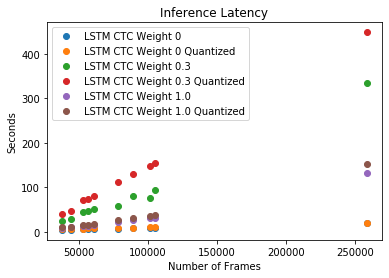

In [54]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open('lab3-quantize-log.json') as f:
    quantized_data = json.load(f)

with open('latency.json') as f:
    data = json.load(f)

name_map = {
    'kamo-naoyuki/mini_an4_asr_train_raw_bpe_valid.acc.best': 'LSTM',
#    'Shinji Watanabe/librispeech_asr_train_asr_transformer_e18_raw_bpe_sp_valid.acc.best': 'Transformer'
}

from collections import defaultdict

plt.xlabel('Number of Frames')
plt.ylabel('Seconds')

for model in name_map.keys():
    print(model)
    len_count = defaultdict(int)
    
    for ctc_weight in ['0', '0.3', '1.0']:
        print(ctc_weight)
        result = data[model][ctc_weight]

        for time, input_len in result:
            len_count[input_len] += 1
        
        latency = [x[0] for x in result]
        input_len = [x[1] for x in result]
        print('normal', np.mean(latency))
        model_name = f'{name_map[model]} CTC Weight {ctc_weight}'
        plt.plot(input_len, latency, 'o', label=model_name)
        
        q_result = quantized_data[model][ctc_weight]

        q_latency = []
        q_len = []
        for time, input_len in q_result:
            if len_count[input_len] > 0:
                q_latency.append(time)
                q_len.append(input_len)
                len_count[input_len] -= 1
        print('quantized', np.mean(q_latency))
        model_name = f'{name_map[model]} CTC Weight {ctc_weight} Quantized'

        plt.plot(q_len, q_latency, 'o', label=model_name)

plt.title('Inference Latency')
plt.legend()
#plt.show()
plt.savefig('figures/lstm_latency.png')

Quantized
0
100
0.3
100
1.0
100
Quantized
0
100
0.3
100
1.0
100


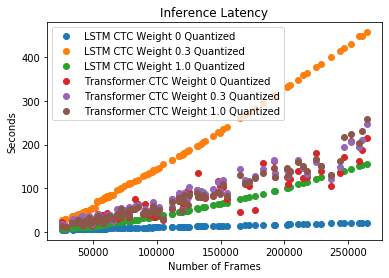

In [56]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open('lab3-quantize-log.json') as f:
    quantized_data = json.load(f)

with open('latency.json') as f:
    data = json.load(f)

name_map = {
    'kamo-naoyuki/mini_an4_asr_train_raw_bpe_valid.acc.best': 'LSTM',
    'Shinji Watanabe/librispeech_asr_train_asr_transformer_e18_raw_bpe_sp_valid.acc.best': 'Transformer'
}
max_len = 300000

plt.xlabel('Number of Frames')
plt.ylabel('Seconds')

for model in name_map.keys():
    print('Quantized')
    model_result = quantized_data[model]
    for ctc_weight, result in model_result.items():
        print(ctc_weight)
        
        sorted_result = sorted(result, key=lambda x:x[1])
        input_len = [x[1] for x in sorted_result if x[1] <= max_len]
        latency = [x[0] for x in sorted_result if x[1] <= max_len]
        print(len(result))
        
        model_name = f'{name_map[model]} CTC Weight {ctc_weight} Quantized'

        plt.plot(input_len, latency, 'o', label=model_name)
'''
    print('Normal')
    model_result = data[model]
    for ctc_weight, result in model_result.items():
        print(ctc_weight)
        
        sorted_result = sorted(result, key=lambda x:x[1])
        input_len = [x[1] for x in sorted_result]
        latency = [x[0] for x in sorted_result]
        print(np.mean(latency))
        
        model_name = f'{name_map[model]} CTC Weight {ctc_weight}'

        plt.plot(input_len, latency, 'o', label=model_name)
'''
plt.title('Inference Latency')
plt.legend()
#plt.show()
plt.savefig('figures/latency.png')